In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import hots_data as hots
from tqdm import tqdm

players=hots.load_replay_chars()
replay_ids = list(players['ReplayID'].unique())
games = players.groupby(['ReplayID', 'Is Winner'])

HOTSLogs data found.


In [2]:
def hero_id_to_group(hero_id):
    return hots.hero_groups.index(hots.heroes.loc[hero_id].Group)

def team_to_comp(team):
    comp = [0] * len(hots.hero_groups)
    for player in team.iterrows():
        group_id = hero_id_to_group(player[1]['HeroID'])
        comp[group_id] += 1
    return tuple(comp)

In [3]:
popular = {}
winner_matrix = {}
for replay_id in tqdm(replay_ids):
    winners = games.get_group((replay_id, 1))
    winning_comp = team_to_comp(winners)
    losers = games.get_group((replay_id, 0))
    losing_comp = team_to_comp(losers)
    popular[winning_comp] = popular.get(winning_comp, 0) + 1
    popular[losing_comp] = popular.get(losing_comp, 0) + 1
    winner_matrix[winning_comp, losing_comp] = winner_matrix.get((winning_comp, losing_comp), 0) + 1 

100%|██████████| 1954853/1954853 [2:07:20<00:00, 255.84it/s]  


In [19]:
def by_win_percent(comp):
    return -np.mean([
        winner_matrix.get((comp, c2), 0) / 
        (winner_matrix.get((comp, c2), 1)+winner_matrix.get((c2, comp), 0)) for c2 in freq_comps])

In [22]:
pop_s = sorted(popular.items(), key=lambda i: i[1])
freq_comps = list(map(lambda k:k[0], reversed(pop_s[-14:])))

In [23]:
sorted(freq_comps, key=by_win_percent)

[(1, 2, 1, 1),
 (1, 1, 1, 2),
 (1, 1, 2, 1),
 (2, 1, 1, 1),
 (3, 1, 1, 0),
 (2, 0, 2, 1),
 (2, 0, 1, 2),
 (3, 0, 1, 1),
 (2, 2, 0, 1),
 (4, 0, 1, 0),
 (3, 1, 0, 1),
 (2, 1, 0, 2),
 (3, 0, 0, 2),
 (4, 0, 0, 1)]

In [24]:
pop_s = sorted(popular.items(), key=lambda i: i[1])
freq_comps = list(map(lambda k:k[0], reversed(pop_s[-15:])))
freq_comps = sorted(freq_comps, key=by_win_percent)[:10]

comp_matchup_p = { key: winner_matrix.get(key, 0) for key in itertools.product(freq_comps,freq_comps) }

In [25]:
def group_label(comp):   
    return "".join(
        ["{}{}{}".format(
            "" if g is 0 else " ",
            c, hots.hero_groups[g][:1] if hots.hero_groups[g][:1] is not 'S' else hots.hero_groups[g][:2]
        ) for g, c in enumerate(comp)])

group_label(freq_comps[0])
comp_labels = [group_label(comp) for comp in freq_comps]


In [30]:
matchup = np.zeros([10, 10], np.float32)
match_total = {}
for x in range(0,10):
    for y in range(0, 10):
        xwin, ywin = comp_matchup_p[(freq_comps[x], freq_comps[y])], comp_matchup_p[(freq_comps[y], freq_comps[x])]
        total = xwin + ywin
        match_total[(x, y)] = total if x is not y else total / 4
        matchup[x, y] = xwin / total if total > 0 else 0

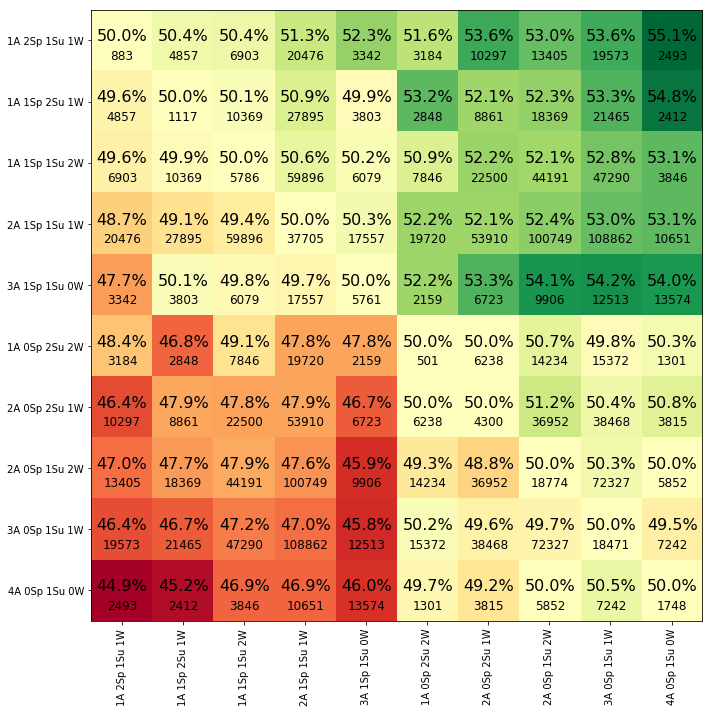

In [31]:
plt.figure(1, figsize=(10,10))
plt.imshow(matchup, cmap=plt.cm.RdYlGn, interpolation='nearest')
plt.xticks(range(0,10), comp_labels, rotation='vertical')
plt.yticks(range(0,10), comp_labels)
for i, cas in enumerate(matchup):
    for j, ratio in enumerate(cas):
        xoff = .07 * 5 - .36
        plt.text(j-xoff, i+.0, "{:.1f}%".format(ratio*100), fontsize=16, color='black', horizontalalignment='center')
        plt.text(j-xoff, i+.3, int(match_total[(i,j)]), fontsize=12, color='black', horizontalalignment='center')

plt.tight_layout()

plt.show()